In [1]:
# imports

%matplotlib inline

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.cross_validation import KFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import BaggingClassifier, VotingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data

df = pd.read_csv('./KobeShots/data.csv')
#df.head()

df.info()
df.set_index('shot_id', inplace=True)

df['action_type'] = df['action_type'].astype('object')
df['combined_shot_type'] = df['combined_shot_type'].astype('category')
df['game_event_id'] = df['game_event_id'].astype('category')
df['game_id'] = df['game_id'].astype('category')
df['period'] = df['period'].astype('category')
df['playoffs'] = df['playoffs'].astype('category')
df['season'] = df['season'].astype('category')
#df['shot_made_flag'] = df['shot_made_flag'].astype('category')
df['shot_type'] = df['shot_type'].astype('category')
df['team_id'] = df['team_id'].astype('category')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [3]:
# Visualize and Prepare Data

df_c = df.copy()

# remove unusefull columns
df_c.drop(['team_id', 'game_id', 'game_event_id', 'team_name'], axis=1, inplace=True)


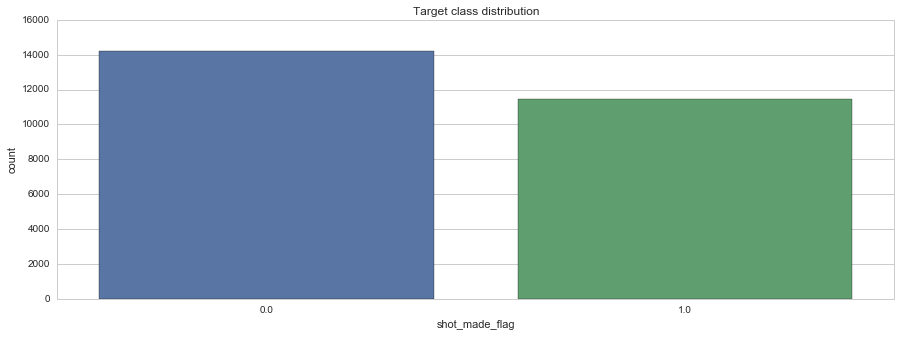

In [4]:
_, axis = plt.subplots(1, figsize=(15, 5))

sns.countplot(x='shot_made_flag', data=df, ax=axis)
axis.set_title('Target class distribution')
plt.show()

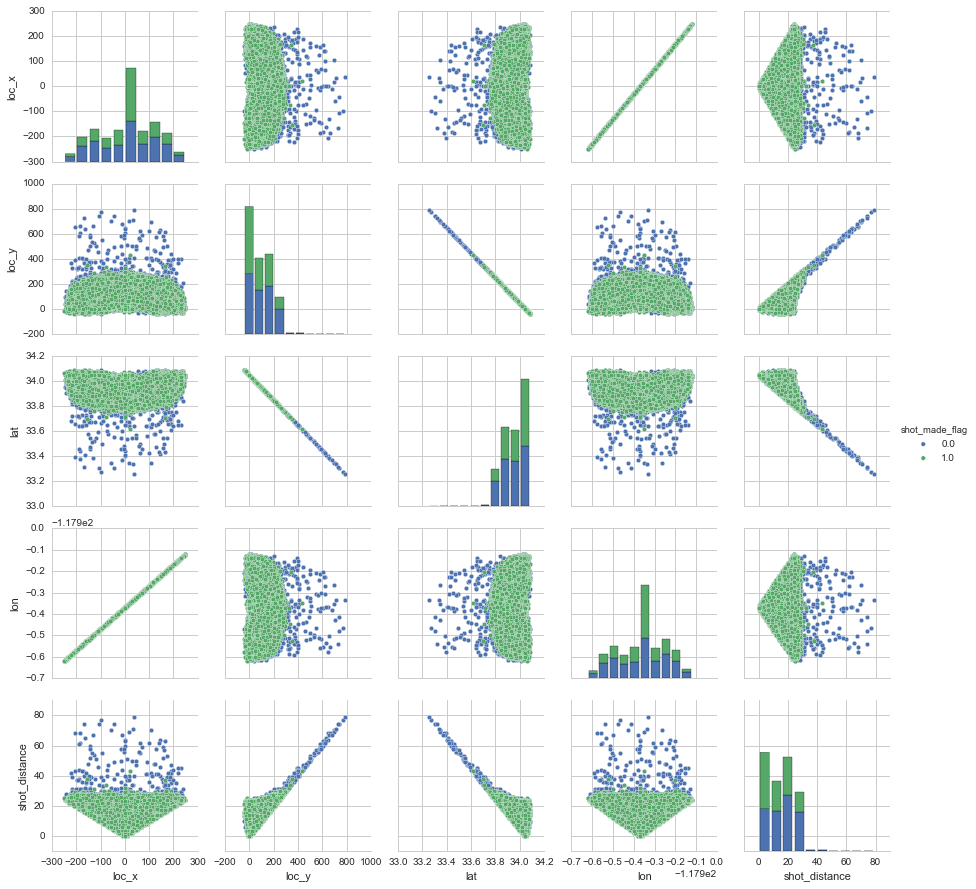

In [5]:
sns.pairplot(data=df, vars=['loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'], hue='shot_made_flag', size=2.5)
plt.show()

In [6]:
# hence lat is related loc_x and lon is related to loc_y, so let drop lat and lon
df_c.drop(['lat', 'lon'], axis=1, inplace=True)

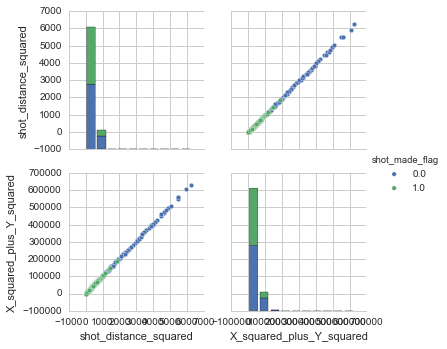

In [7]:
# let see is there any relation between loc_x, loc_y and shot_distance
df_c['shot_distance_squared'] = df_c['shot_distance']**2
df_c['X_squared_plus_Y_squared'] = df_c['loc_x']**2 + df_c['loc_y']**2

sns.pairplot(data=df_c, vars=['shot_distance_squared', 'X_squared_plus_Y_squared'], hue='shot_made_flag', size=2.5)
plt.show()

In [8]:
# We observe that shot_distance squared is sum of loc_x squared and loc_y squared
df_c.drop(['shot_distance_squared', 'X_squared_plus_Y_squared'], axis=1, inplace=True)

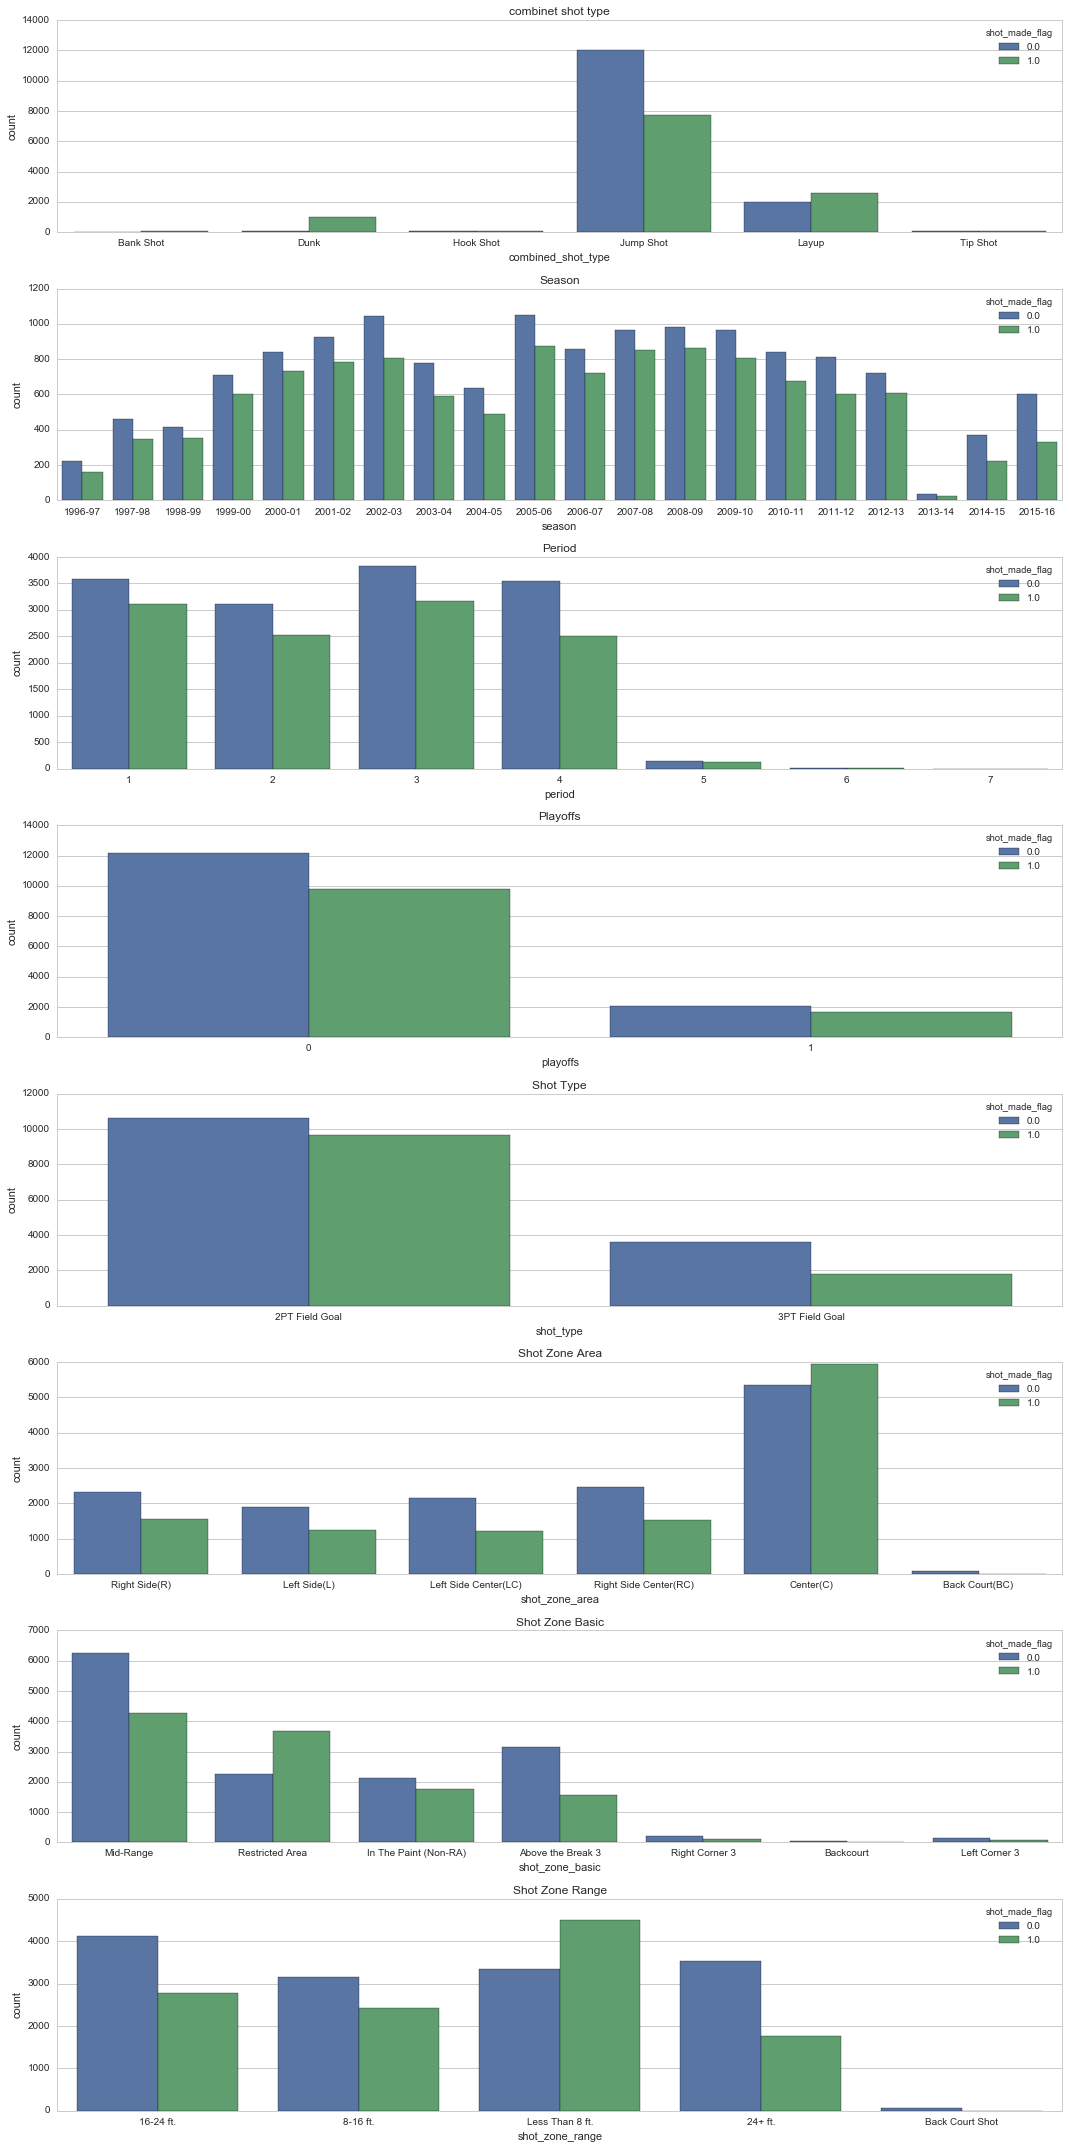

In [9]:
fig, axarray = plt.subplots(8, figsize=(15, 30))

sns.countplot(x='combined_shot_type', hue='shot_made_flag', data=df, ax=axarray[0])
axarray[0].set_title('combinet shot type')
sns.countplot(x='season', hue='shot_made_flag', data=df, ax=axarray[1])
axarray[1].set_title('Season')
sns.countplot(x='period', hue='shot_made_flag', data=df, ax=axarray[2])
axarray[2].set_title('Period')
sns.countplot(x='playoffs', hue='shot_made_flag', data=df, ax=axarray[3])
axarray[3].set_title('Playoffs')
sns.countplot(x='shot_type', hue='shot_made_flag', data=df, ax=axarray[4])
axarray[4].set_title('Shot Type')
sns.countplot(x='shot_zone_area', hue='shot_made_flag', data=df, ax=axarray[5])
axarray[5].set_title('Shot Zone Area')
sns.countplot(x='shot_zone_basic', hue='shot_made_flag', data=df, ax=axarray[6])
axarray[6].set_title('Shot Zone Basic')
sns.countplot(x='shot_zone_range', hue='shot_made_flag', data=df, ax=axarray[7])
axarray[7].set_title('Shot Zone Range')


plt.tight_layout()
plt.show()

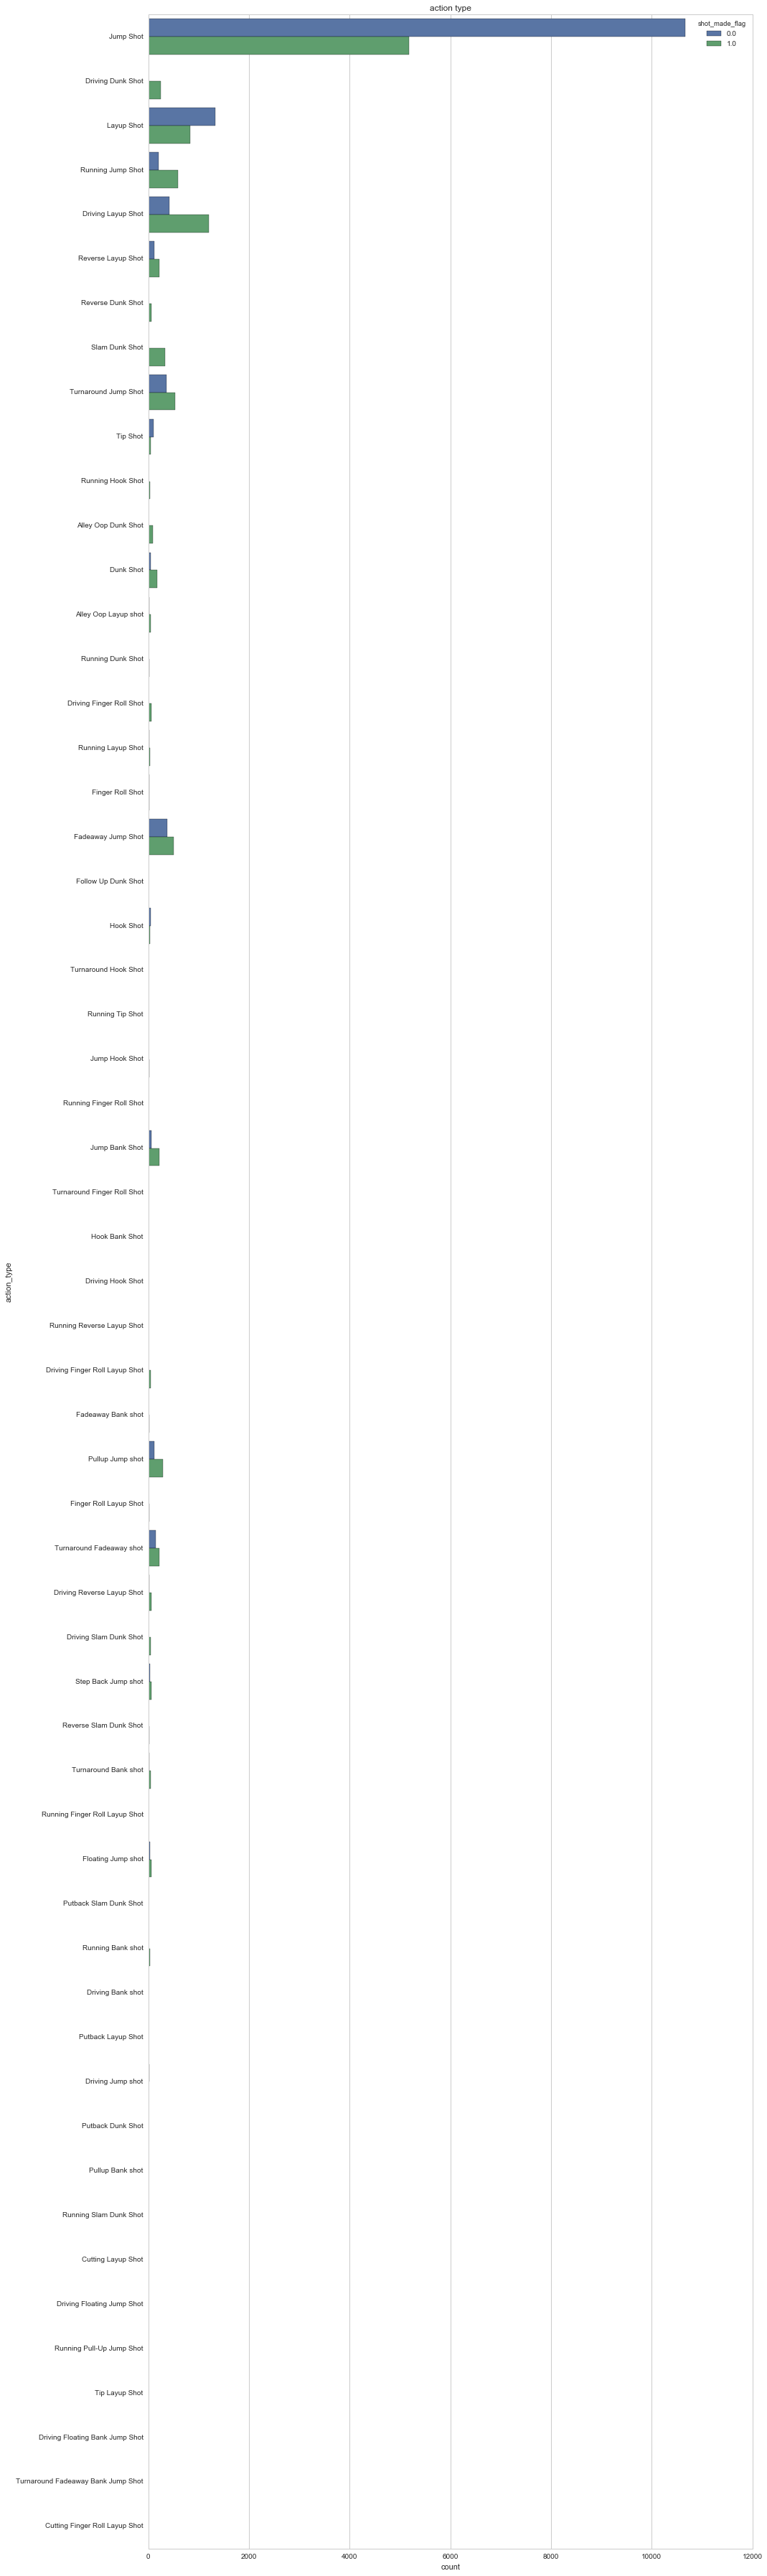

In [10]:
fig, ax = plt.subplots(1, figsize=(15, 50))

sns.countplot(y='action_type', hue='shot_made_flag', data=df, ax=ax)
ax.set_title('action type')
plt.tight_layout()
plt.show()

In [11]:
# Data transformation

# new features

# lets have last_5_sec_in_period as one feature
df_c['total_remaining_time'] = 60 * df_c['minutes_remaining'] + df_c['seconds_remaining']
df_c['last_5_sec_in_period'] = df_c['total_remaining_time'] <= 5
df_c['last_5_sec_in_period'] = df_c['last_5_sec_in_period'].astype('category')

df_c.drop(['total_remaining_time', 'minutes_remaining', 'seconds_remaining'], axis=1, inplace=True)

# Matchup - (away/home)
df_c['home_play'] = df_c['matchup'].str.contains('vs').astype('category')
df_c.drop('matchup', axis=1, inplace=True)

# Game date
df_c['game_date'] = pd.to_datetime(df_c['game_date'])
df_c['game_year'] = df_c['game_date'].dt.year.astype('category')
df_c['game_month'] = df_c['game_date'].dt.month.astype('category')
df_c.drop('game_date', axis=1, inplace=True)

# loc_x and loc_y binning
df_c['loc_x'] = pd.cut(df_c['loc_x'], 25)
df_c['loc_y'] = pd.cut(df_c['loc_y'], 25)
df_c['shot_distance'] = pd.cut(df_c['shot_distance'], 25)

# replace least common action by others

least_common_action = df_c['action_type'].value_counts().sort_values().index.values[:10]
df_c.loc[df_c['action_type'].isin(least_common_action), 'action_type'] = 'other'



In [12]:
unknown_mask = df['shot_made_flag'].isnull()
train = df_c[~unknown_mask].copy()


In [13]:
# fig, (axis1, axis2, axis3) = plt.subplots(1,3, figsize=(15,5))
# embark_perc = train_df[['Embarked', 'Survived']].groupby('Embarked', as_index=False).mean()
# sns.barplot(x='Embarked', y='Survived', data=embark_perc, order=['S','C','Q'], ax=axis3)

def barPlot(column, on_x_axis=False, fsize=None):
    if fsize is None:
        fsize = (15, 5)
        
    _, ax = plt.subplots(1, figsize=fsize)
    percent = train[[column, 'shot_made_flag']].groupby(column, as_index=False).mean()
    if on_x_axis:
        sns.barplot(y=column, x='shot_made_flag', data=percent, ax=ax)
    else:
        sns.barplot(x=column, y='shot_made_flag', data=percent, ax=ax)
    

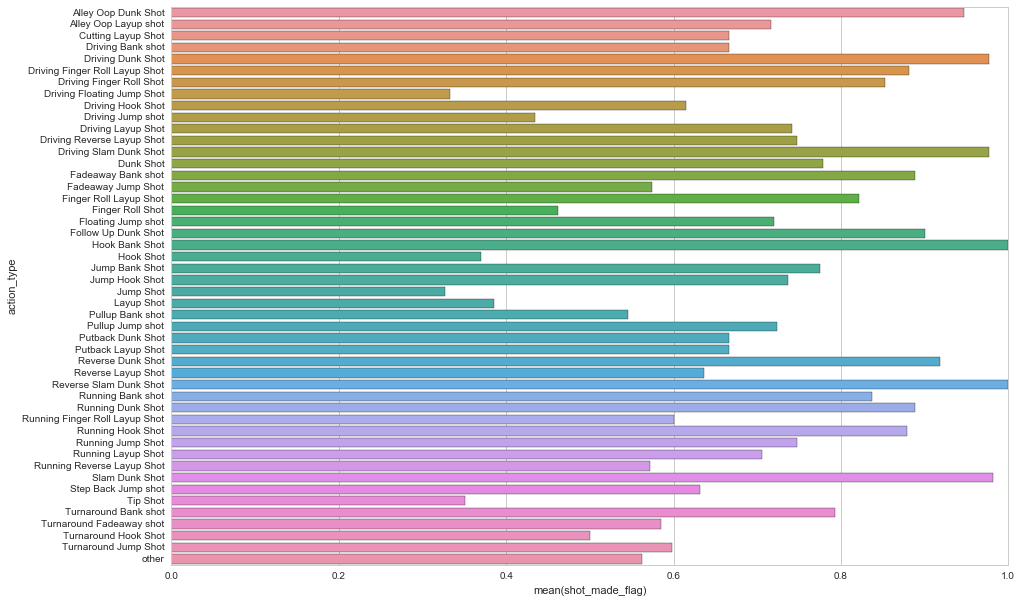

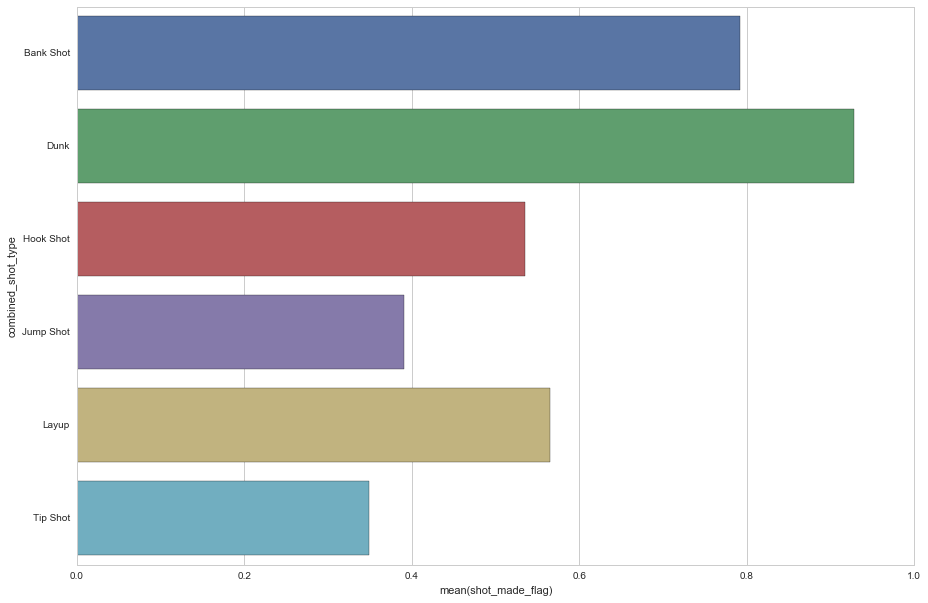

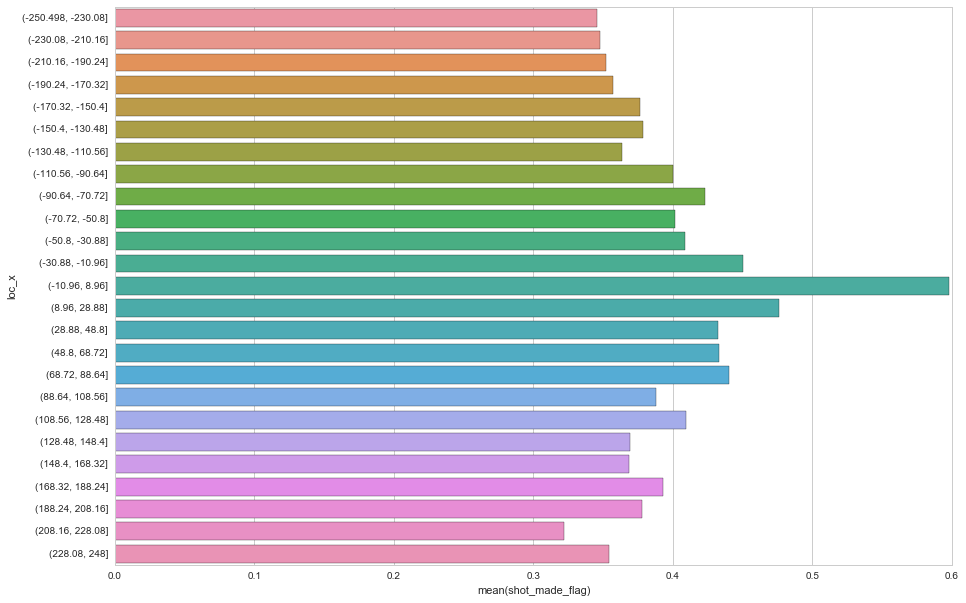

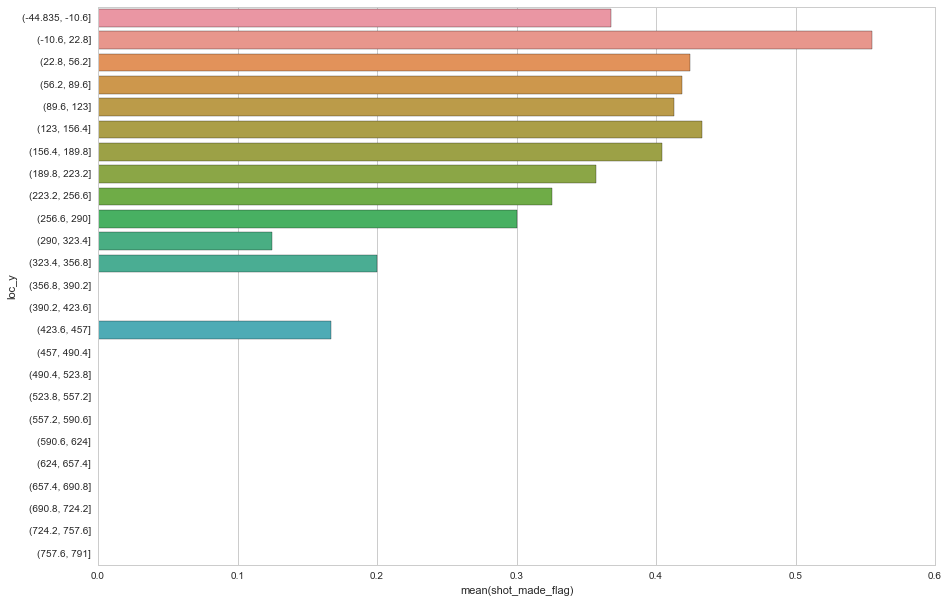

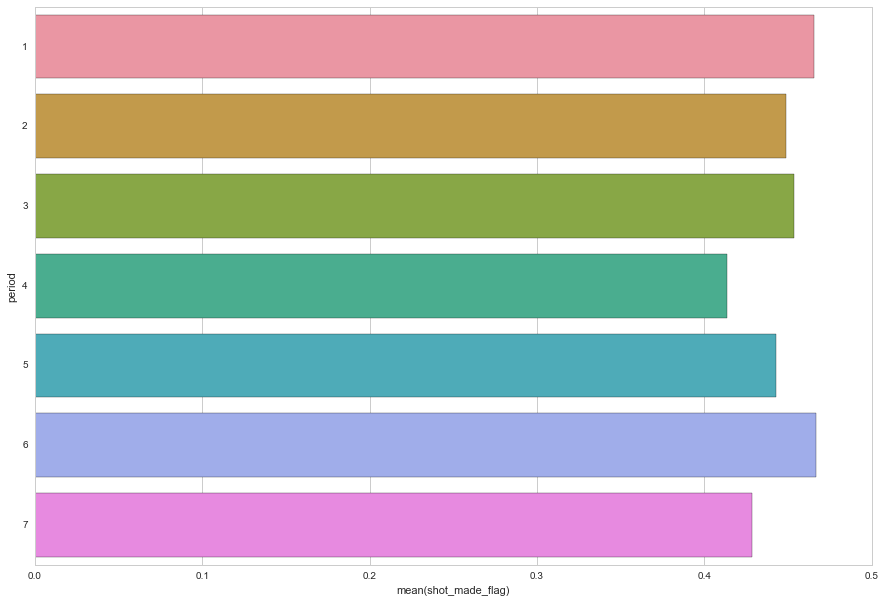

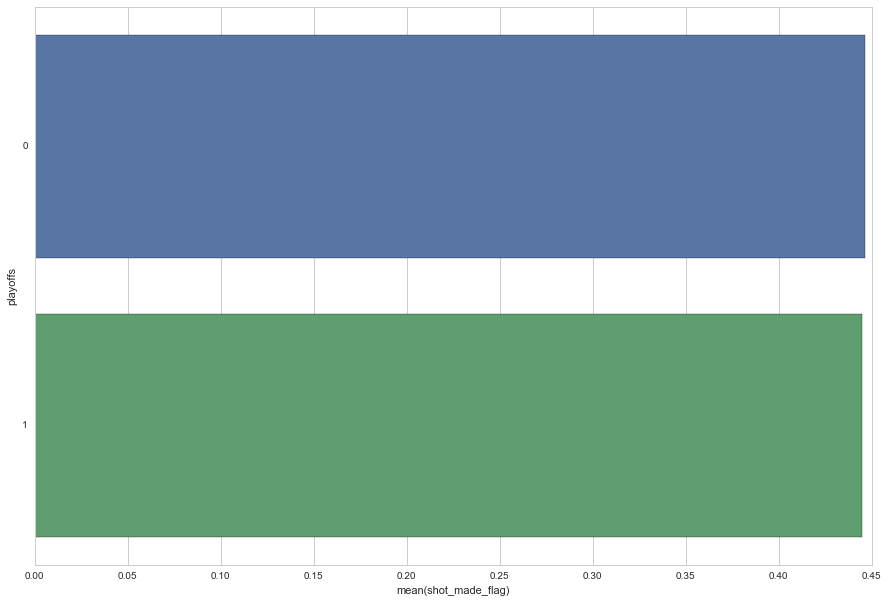

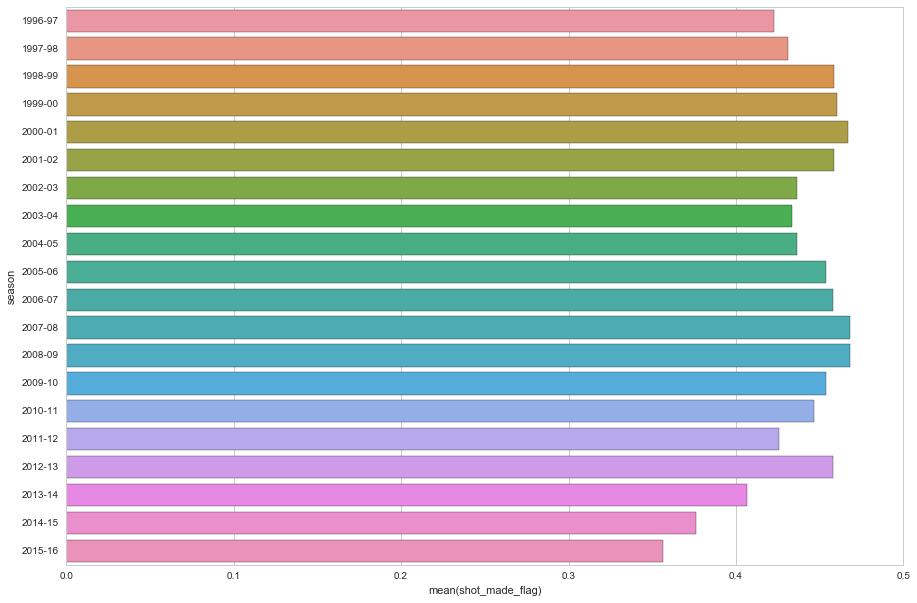

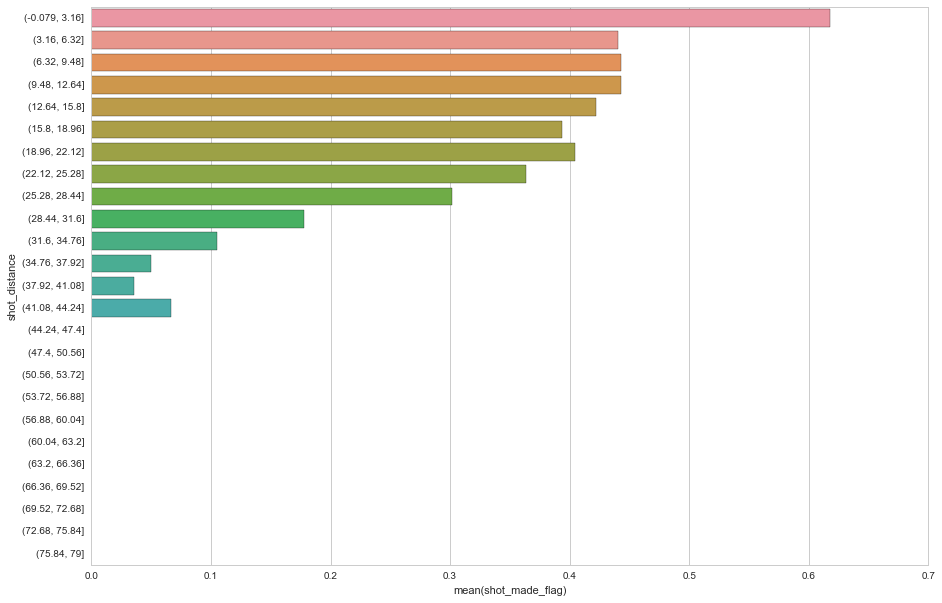

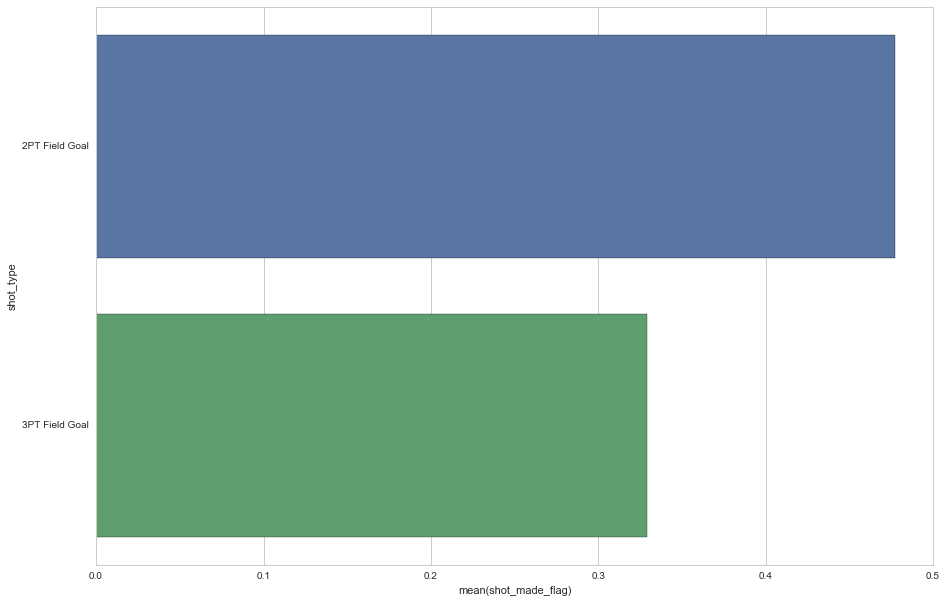

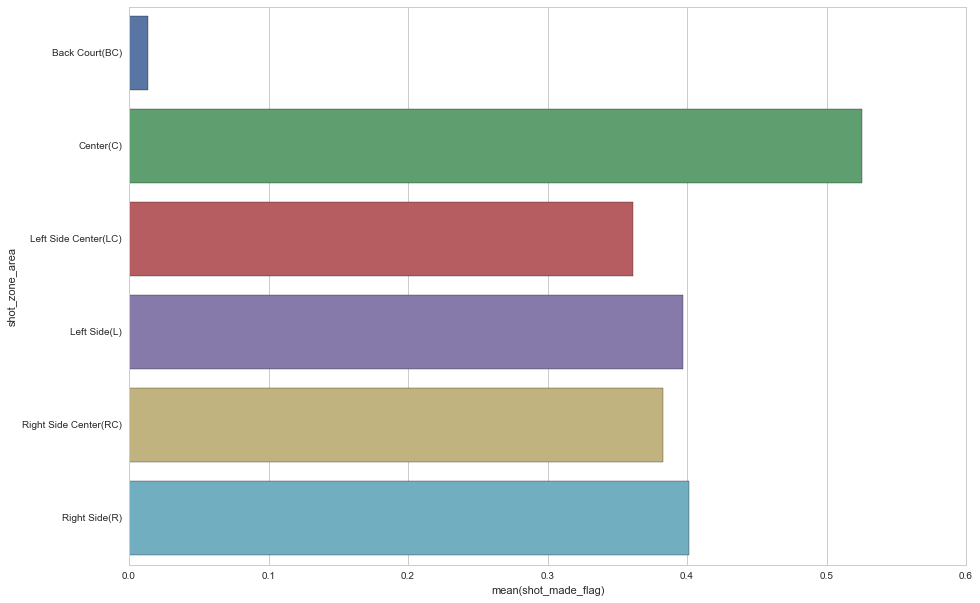

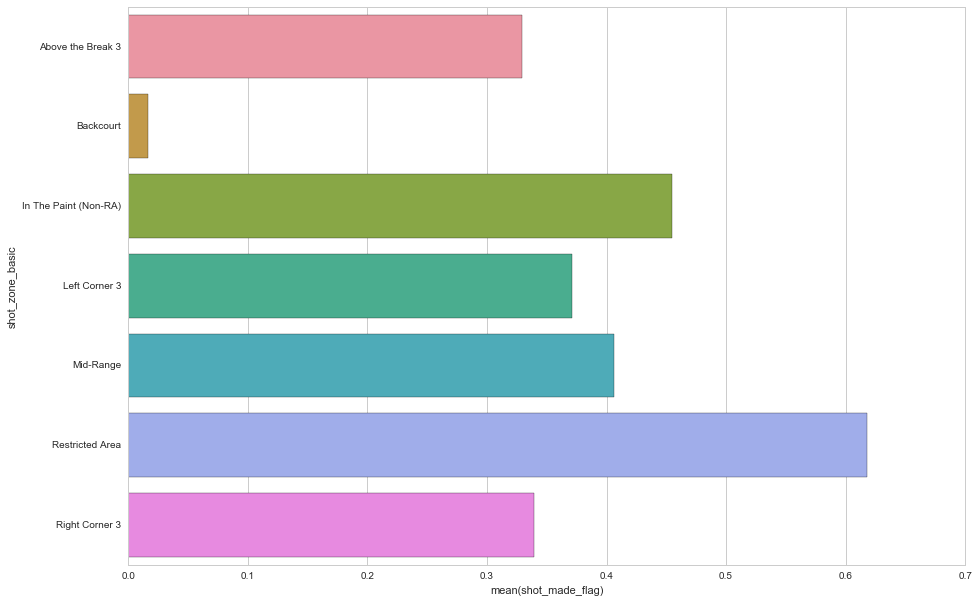

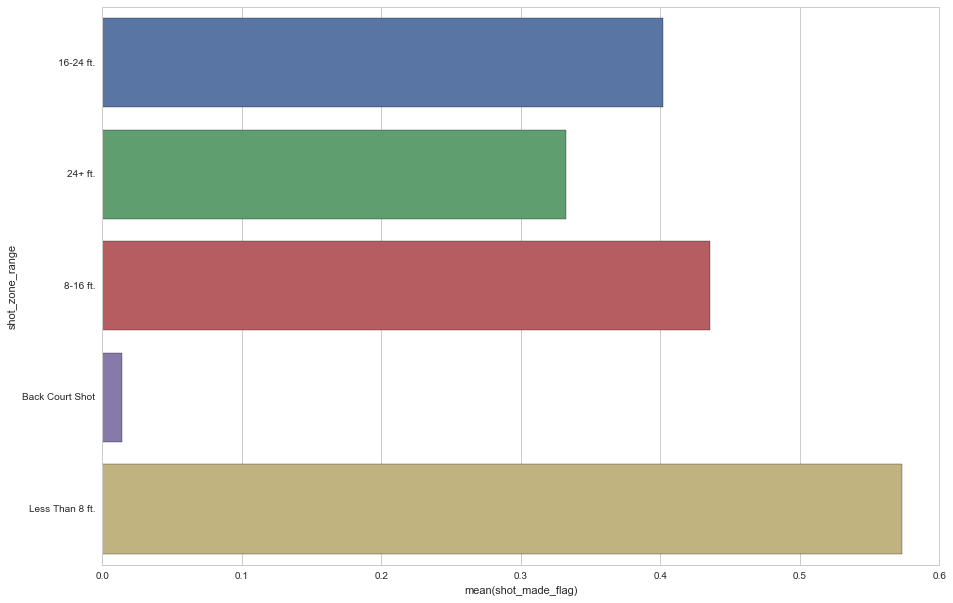

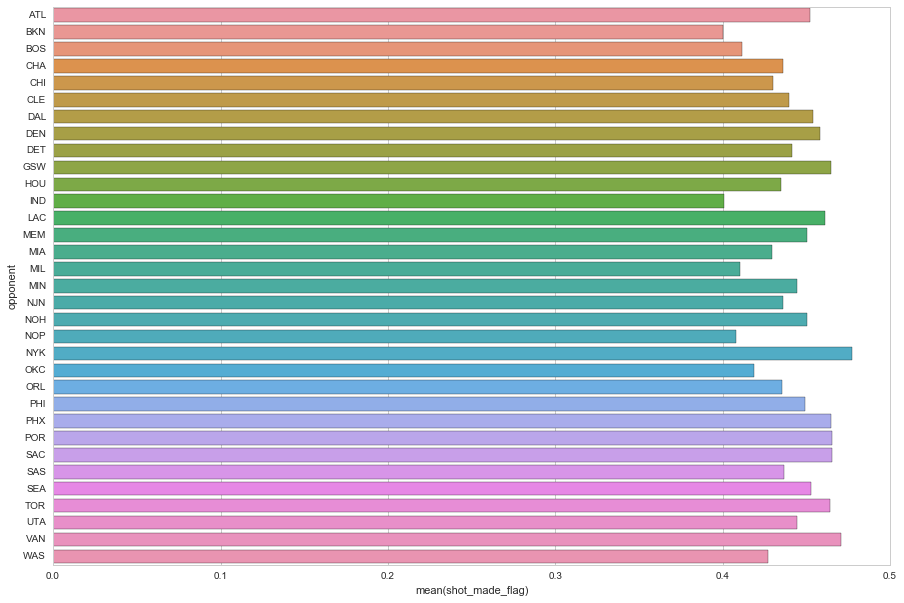

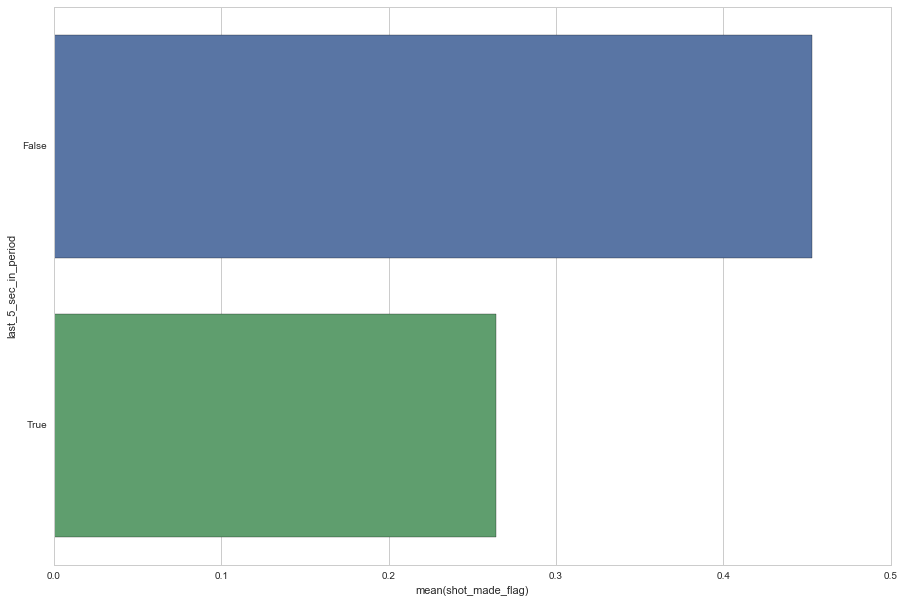

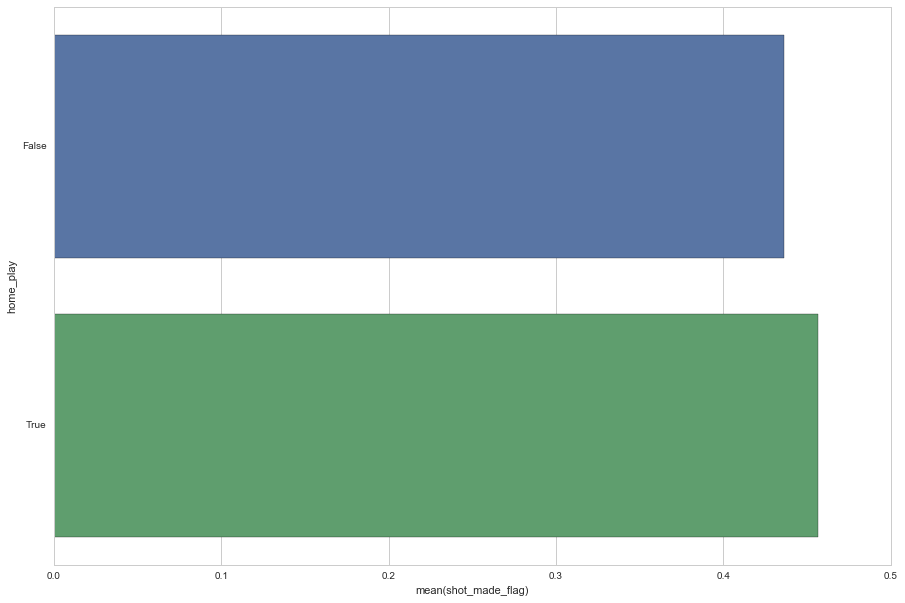

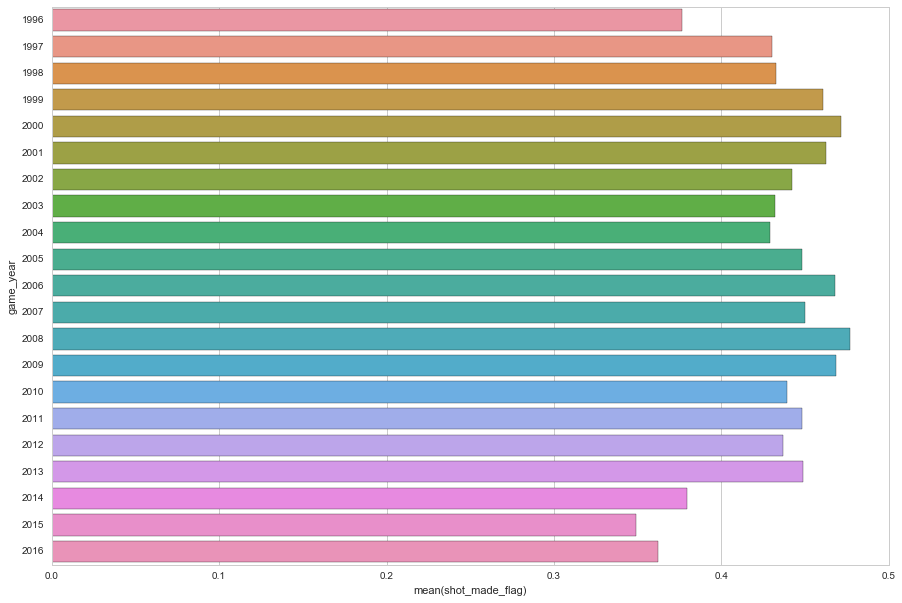

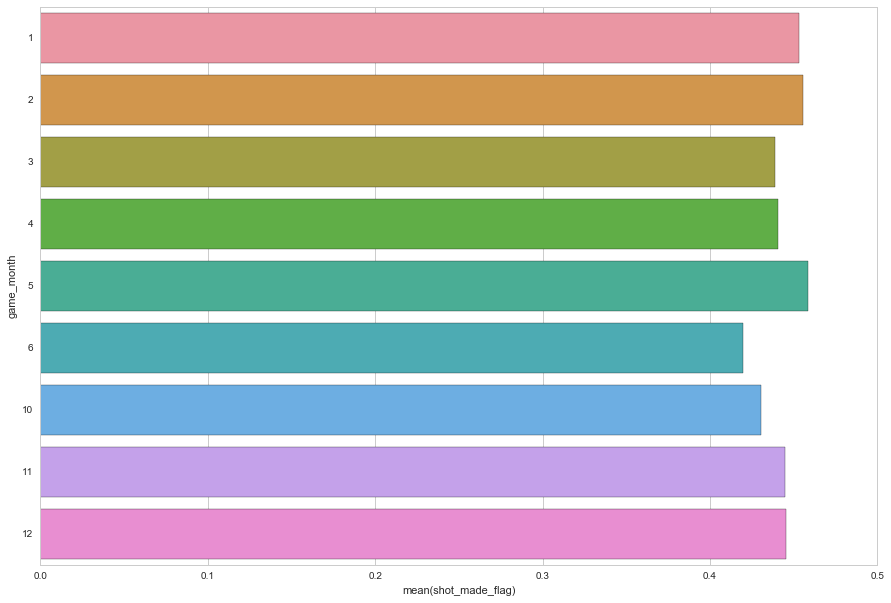

In [14]:
#train.columns
for _, column in enumerate(train.columns):
    if column != 'shot_made_flag':
        barPlot(column, True, (15,10))

In [15]:
# From above bar plot observation, less informative features shoud be droped
labels = df_c['shot_made_flag'].copy()
df_c.drop(['loc_x', 'period', 'playoffs', 'season', 'opponent', 'home_play', 'game_month', 'shot_made_flag'], axis=1, inplace=True)
# dropping loc_x beacuse loc_x is dependent ob loc_y and shot_distance

In [16]:
# Encode categorial variables
for _, column in enumerate(df_c.columns):
    #assert len(test.columns) == len(train.columns)-1, '{0}, {1}'.format(len(test.columns), len(train.columns))
    dummies = pd.get_dummies(df_c[column])
    dummies = dummies.add_prefix('{}@'.format(column))
    df_c.drop(column, axis=1, inplace=True)
    df_c = df_c.join(dummies)


In [17]:
# Features Selection
X = df_c[~unknown_mask].copy()
Y = labels[~unknown_mask].copy()

test = df_c[unknown_mask].copy()


In [18]:
# According to RandomForestClassifier
# Top 30 features


model = RandomForestClassifier()
model.fit(X,Y)

feat_randomForest = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['imp'])
feat_rf_imp_30 = feat_randomForest.sort_values('imp', ascending=False).head(30).index
feat_rf_imp_30

Index(['action_type@Jump Shot', 'action_type@Layup Shot',
       'shot_zone_range@Less Than 8 ft.', 'game_year@2009', 'game_year@2012',
       'game_year@2010', 'loc_y@(-10.6, 22.8]', 'combined_shot_type@Jump Shot',
       'loc_y@(22.8, 56.2]', 'loc_y@(56.2, 89.6]', 'loc_y@(89.6, 123]',
       'game_year@2008', 'shot_distance@(-0.079, 3.16]',
       'combined_shot_type@Dunk', 'shot_zone_area@Right Side(R)',
       'action_type@Running Jump Shot', 'game_year@2002', 'game_year@2004',
       'game_year@2013', 'shot_zone_area@Left Side(L)', 'game_year@2011',
       'game_year@2003', 'game_year@2000', 'game_year@2005', 'game_year@2001',
       'game_year@2007', 'game_year@2006', 'game_year@2014',
       'loc_y@(123, 156.4]', 'game_year@1999'],
      dtype='object')

In [19]:
# Variance Threshold
# Find all features with more than 90 % variance in values
threshold = 0.9
vt = VarianceThreshold().fit(X)

# Find feature name
feat_var_threshold = df_c.columns[vt.variances_ > threshold*(1-threshold)]

feat_var_threshold

Index(['action_type@Jump Shot', 'combined_shot_type@Jump Shot',
       'combined_shot_type@Layup', 'loc_y@(-10.6, 22.8]', 'loc_y@(22.8, 56.2]',
       'loc_y@(123, 156.4]', 'shot_distance@(-0.079, 3.16]',
       'shot_distance@(12.64, 15.8]', 'shot_distance@(15.8, 18.96]',
       'shot_distance@(18.96, 22.12]', 'shot_distance@(22.12, 25.28]',
       'shot_type@2PT Field Goal', 'shot_type@3PT Field Goal',
       'shot_zone_area@Center(C)', 'shot_zone_area@Left Side Center(LC)',
       'shot_zone_area@Left Side(L)', 'shot_zone_area@Right Side Center(RC)',
       'shot_zone_area@Right Side(R)', 'shot_zone_basic@Above the Break 3',
       'shot_zone_basic@In The Paint (Non-RA)', 'shot_zone_basic@Mid-Range',
       'shot_zone_basic@Restricted Area', 'shot_zone_range@16-24 ft.',
       'shot_zone_range@24+ ft.', 'shot_zone_range@8-16 ft.',
       'shot_zone_range@Less Than 8 ft.'],
      dtype='object')

In [20]:
# Univariate feature selection
# top 20 fratures

#Features must be positive before applying test
X_minmax = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, Y)
feature_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': X_scored.scores_
    })
feat_chi2_imp_20 =feature_scoring.sort_values('score', ascending=False).head(20)['feature'].values
feat_chi2_imp_20

array(['combined_shot_type@Dunk', 'action_type@Jump Shot',
       'shot_zone_basic@Restricted Area', 'shot_distance@(-0.079, 3.16]',
       'action_type@Driving Layup Shot', 'shot_zone_range@Less Than 8 ft.',
       'loc_y@(-10.6, 22.8]', 'action_type@Slam Dunk Shot',
       'shot_type@3PT Field Goal', 'action_type@Driving Dunk Shot',
       'shot_zone_area@Center(C)', 'action_type@Running Jump Shot',
       'shot_zone_range@24+ ft.', 'shot_zone_basic@Above the Break 3',
       'combined_shot_type@Layup', 'combined_shot_type@Jump Shot',
       'shot_distance@(25.28, 28.44]', 'action_type@Jump Bank Shot',
       'action_type@Pullup Jump shot', 'last_5_sec_in_period@True'], dtype=object)

In [21]:
# Recursive Feature Elemination 
# Top 20 features

rfe = RFE(LogisticRegression(), 20)
rfe.fit(X, Y)

feature_rfe_rank = pd.DataFrame({
        'feature': X.columns,
        'score': rfe.ranking_
    })

feat_rfe_imp_20 = feature_rfe_rank[feature_rfe_rank['score'] == 1]['feature'].values
feat_rfe_imp_20

array(['action_type@Driving Dunk Shot',
       'action_type@Driving Finger Roll Layup Shot',
       'action_type@Driving Finger Roll Shot',
       'action_type@Driving Jump shot', 'action_type@Dunk Shot',
       'action_type@Fadeaway Bank shot', 'action_type@Hook Bank Shot',
       'action_type@Hook Shot', 'action_type@Jump Shot',
       'action_type@Layup Shot', 'action_type@Running Hook Shot',
       'action_type@Slam Dunk Shot', 'combined_shot_type@Dunk',
       'combined_shot_type@Tip Shot', 'loc_y@(356.8, 390.2]',
       'loc_y@(390.2, 423.6]', 'shot_distance@(31.6, 34.76]',
       'shot_distance@(34.76, 37.92]', 'shot_zone_area@Back Court(BC)',
       'shot_zone_range@Back Court Shot'], dtype=object)

In [22]:
# Final feature selection
# Finallt features selected by all method will be merged together

features = np.hstack([
        feat_rf_imp_30,
        feat_var_threshold,
        feat_chi2_imp_20,
        feat_rfe_imp_20
        
    ])

features = np.unique(features)
print('Important features:\n')

for i, f in enumerate(features):
    print('{0}. {1}'.format(i, f))

Important features:

0. action_type@Driving Dunk Shot
1. action_type@Driving Finger Roll Layup Shot
2. action_type@Driving Finger Roll Shot
3. action_type@Driving Jump shot
4. action_type@Driving Layup Shot
5. action_type@Dunk Shot
6. action_type@Fadeaway Bank shot
7. action_type@Hook Bank Shot
8. action_type@Hook Shot
9. action_type@Jump Bank Shot
10. action_type@Jump Shot
11. action_type@Layup Shot
12. action_type@Pullup Jump shot
13. action_type@Running Hook Shot
14. action_type@Running Jump Shot
15. action_type@Slam Dunk Shot
16. combined_shot_type@Dunk
17. combined_shot_type@Jump Shot
18. combined_shot_type@Layup
19. combined_shot_type@Tip Shot
20. game_year@1999
21. game_year@2000
22. game_year@2001
23. game_year@2002
24. game_year@2003
25. game_year@2004
26. game_year@2005
27. game_year@2006
28. game_year@2007
29. game_year@2008
30. game_year@2009
31. game_year@2010
32. game_year@2011
33. game_year@2012
34. game_year@2013
35. game_year@2014
36. last_5_sec_in_period@True
37. loc_

In [23]:
# Dataset with important features

X = X.ix[:, features]
test = test.ix[:, features]

In [24]:
print('Train dataset shape:\t{}'.format(X.shape))
print('Test dataset shape:\t{}'.format(test.shape))
print('Train labels shape:\t{}'.format(Y.shape))

Train dataset shape:	(25697, 69)
Test dataset shape:	(5000, 69)
Train labels shape:	(25697,)


In [25]:
# Evalute algorithm

rand_state = 7
num_of_cpu = 4
num_folds = 5
num_of_instance = len(X)
scoring = 'log_loss'

kfold = KFold(n=num_of_instance, n_folds=num_folds, random_state=rand_state)


In [26]:
# Performance of some basic models
models = []

models.append(('DTC', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('BNB', BernoulliNB()))
models.append(('MNB', MultinomialNB()))
models.append(('LRA', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))



# Evalute each result

results = []
names = []

for name, model in models:
    cv_result = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=num_of_cpu)
    results.append(cv_result)
    names.append(name)
    print('{0}:\t{1:.5f} +/- {2:.5f}'.format(name, cv_result.mean(), cv_result.std()))



DTC:	-4.79402 +/- 0.89981
GNB:	-5.32811 +/- 2.72214
BNB:	-1.20879 +/- 0.07993
MNB:	-0.89724 +/- 0.04743
LRA:	-0.60941 +/- 0.00307
LDA:	-0.61144 +/- 0.00294
KNN:	-2.08675 +/- 0.23971


In [27]:
# Bagging of DecisionTreeClassifier

bag_DTC = DecisionTreeClassifier()
num_trees = 100

model = BaggingClassifier(base_estimator=bag_DTC, n_estimators=num_trees, random_state=num_of_cpu)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=num_of_cpu)
print("{0:.5f} +/- {1:.5f}".format(results.mean(), results.std()))

-0.88350 +/- 0.08484


In [28]:
# AdaBoost
model = AdaBoostClassifier(n_estimators=100, random_state=rand_state)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=num_of_cpu)
print("{0:.5f} +/- {1:.5f}".format(results.mean(), results.std()))

-0.69075 +/- 0.00047


In [29]:
# Stochastic Gradient Boosting

model = GradientBoostingClassifier(n_estimators=100, random_state=rand_state)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=num_of_cpu)
print("{0:.5f} +/- {1:.5f}".format(results.mean(), results.std()))

-0.61105 +/- 0.00451


In [39]:
# Random Forest

num_trees = 100
num_features = 10

model = RandomForestClassifier(n_estimators=num_trees, max_features=num_features)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=num_of_cpu)
print("{0:.5f} +/- {1:.5f}".format(results.mean(), results.std()))

-0.85048 +/- 0.09692


In [30]:
### Hyperparameter tuning ###

# Logistic Regression

LRA_G = GridSearchCV(
    estimator = LogisticRegression(random_state=rand_state),
    param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 1, 10, 100, 1000]
    }, 
    cv = kfold, 
    scoring=scoring,
    n_jobs = num_of_cpu)

LRA_G.fit(X, Y)

print(LRA_G.best_score_)
print(LRA_G.best_params_)


-0.609411572305
{'C': 1, 'penalty': 'l2'}


In [31]:
# Linear Discriminant Analysis

LDA_G = GridSearchCV(
    estimator = LinearDiscriminantAnalysis(),
    param_grid = {
        'solver': ['lsqr'],
        'shrinkage': [0, 0.25, 0.5, 0.75, 1],
        'n_components': [None, 2, 5, 10]
    }, 
    cv = kfold, 
    scoring=scoring,
    n_jobs = num_of_cpu)

LDA_G.fit(X, Y)

print(LDA_G.best_score_)
print(LDA_G.best_params_)

-0.611437871148
{'n_components': None, 'solver': 'lsqr', 'shrinkage': 0}


In [32]:
# AdaBoost

ADA_G = GridSearchCV(
    estimator = AdaBoostClassifier(random_state=rand_state),
    param_grid = {
        'algorithm': ['SAMME', 'SAMME.R'],
        'n_estimators': [10, 25, 50],
        'learning_rate': [1e-3, 1e-2, 1e-1]
    }, 
    cv = kfold, 
    scoring=scoring,
    n_jobs = num_of_cpu)

ADA_G.fit(X, Y)

print(ADA_G.best_score_)
print(ADA_G.best_params_)


-0.641203422605
{'algorithm': 'SAMME.R', 'learning_rate': 0.001, 'n_estimators': 10}


In [37]:
# Gradient Boosting

GBC_G = GridSearchCV(
    estimator = GradientBoostingClassifier(warm_start=True, random_state=rand_state),
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [2, 3, 4],
        'max_features': [10, 15, 20],
        'learning_rate': [1e-1, 1]
    }, 
    cv = kfold,
    scoring=scoring,
    n_jobs = num_of_cpu)

GBC_G.fit(X, Y)

print(GBC_G.best_score_)
print(GBC_G.best_params_)

-0.609877818933
{'learning_rate': 0.1, 'max_features': 10, 'max_depth': 3, 'n_estimators': 200}


In [41]:
# Random Forest

RFC_G = GridSearchCV(
    estimator = RandomForestClassifier(warm_start=True, random_state=rand_state),
    param_grid = {
        'n_estimators': [100, 200],
        'criterion': ['gini', 'entropy'],
        'max_features': [18, 20],
        'max_depth': [8, 10],
        'bootstrap': [True]
    }, 
    cv = kfold,
    scoring=scoring,
    n_jobs = num_of_cpu)

RFC_G.fit(X, Y)

print(RFC_G.best_score_)
print(RFC_G.best_params_)

-0.610238099299
{'criterion': 'entropy', 'max_features': 20, 'bootstrap': True, 'max_depth': 10, 'n_estimators': 200}


In [42]:
# Voting ensemble

MODEL = []

MODEL.append(('LRA', LogisticRegression(penalty='l2', C=1)))
MODEL.append(('LDA', LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0)))
MODEL.append(('GBC', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, 
                                                max_features=3, warm_start=True, random_state=rand_state)))
MODEL.append(('RFC', RandomForestClassifier(warm_start=True, n_estimators=200, 
                                            criterion='entropy', max_features=20, max_depth=10, 
                                            bootstrap=True, random_state=rand_state)))

# create the ensemble model
ensembled_model = VotingClassifier(MODEL, voting='soft', weights=[3, 1, 2, 1])

results = cross_val_score(ensembled_model, X, Y, cv=kfold, scoring=scoring, n_jobs=num_of_cpu)
print("{0:.5f} +/- {1:.5f}".format(results.mean(), results.std()))

-0.60850 +/- 0.00307


In [43]:
# Predictions on test set

ensembled_model.fit(X, Y)
predictions = ensembled_model.predict_proba(test)

submission = pd.DataFrame()
submission["shot_id"] = test.index
submission["shot_made_flag"]= predictions[:,0]

submission.to_csv("KobeShotsSub.csv",index=False)